# WHOBS-IE-100
## Notionally Optimal, 100% Wind+Hydrogen+Other+Battery+Solar Electricity System for Ireland (IE)

- **Project:** [OESM-IE](http://ecrn.eeng.dcu.ie/projects/oesm-ie)
- **Funding:** [Sustainable Energy Authority of Ireland (SEAI) Research, Development and Demonstration Programme](https://www.seai.ie/grants/research-funding/research-development-and-demonstration-fund/), award reference SEAI RDD/00246 2018.
- **Author:** Barry McMullin, barry.mcmullin@dcu.ie
- **Last modified:** 14 June 2020
- **© 2020:** [Dublin City University](http://www.dcu.ie/)
- **Licence:** [GNU GENERAL PUBLIC LICENSE Version 3](https://www.gnu.org/licenses/gpl-3.0.en.html)

This is a derived from: [Optimal Wind+Hydrogen+Other+Battery+Solar (WHOBS) electricity systems for European countries](https://github.com/PyPSA/WHOBS)

Download the [Jupyter notebook](https://jupyter.org/) at: **TODO**


## Introduction/motivation

[WHOBS](https://github.com/PyPSA/WHOBS), and the associated interactive web application [model.energy](https://model.energy/), allows modelling of notionally optimised "firm" electricity generation for a given level of (constant/"baseload") capacity, based exclusively on *variable* renewable (VRE: here limited to wind and solar) sources, coupled with hydrogen and/or battery storage (to cover "when the wind doesn't blow and the sun doesn't shine"). 

Wind and solar resource variability is configured for states within Europe using historical data from [Renewables.ninja](https://www.renewables.ninja/) ([model.energy](https://model.energy/) extends this coverage to global geographical locations using other data sources).

**WHOBS-IE-100** adapts WHOBS to model delivery of **100%** of electricity demand from VRE only for one particular European country (**Ireland**), based on [historical load data](http://www.eirgridgroup.com/how-the-grid-works/renewables/) from the [Irish Transmission System Operator (TSO) eirgrid](http://www.eirgridgroup.com/).

This allows illustration and exploration of the (rough) trade-off between:

- Raw VRE *overprovision* (building more VRE capacity than can be directly dispatched at all times, but meaning that more demand can be covered directly by instantaneous VRE generations)
- Dispatch down (discarding some generation when it is in excess of instantaneous load)
- Storage (storing some generation when it is in excess of instantaneous load)
    - Short term, high efficiency storage: battery
    - Long term, low efficiency storage: hydrogen
- Interconnection with a larger, external, grid: here modelled (simplistically) as a single, aggregated, fixed power capacity link to an indefinitely large external energy storage (effectively it is assumed that a larger external grid will facilitate temporal buffering from the point of view of the local system, in a manner analogous to local storage, constrained only by the power capacity and efficiency of the interconnector(s) themselves). 


## Enhancements over WHOBS?

+ Added (crude) representation of external interconnection
+ Added more flexible options on temporal resolution - not just 1 or 3 hours, but arbitrary number of hours
+ Added/refactored mechanism for flexibly setting options for a particular interactive model run, capturing the summary results, and accumulating the information on these runs in two data structures, `run_configs` and `ru_stats`.
+ Instead of H2 underground vs steel tank storage being mutually exclusive, both are made available for deployment unconditionally, but user can (optionally) set `e_extendable_max` limits on each separately (which could potentially be based, even if loosely, on actual available geology, such as salt caverns in NI).
+ Similarly, H2 overall is available for deployment unconditionally: but obviously if both storage options are set to zero capacity, no actual H2 electrolysis or electricity generation will actually be provisioned.


## TODO?

+ Create/release as github project: add link in metadata block at top?
+ Need to **critically** investigate the summary statistic here labelled as "LCOE" (in `run_stats`): it's not clear that that is actually what it represents (if not, what is it? and how **can** LCOE be calculated?).
+ Bypass `pyomo` to improve solver performance? (I don't think there is anything in this model that *requires* `pyomo`?). Would require (modest) recoding of `extra_functionality`?
+ Link to the [detailed caveats in the WHOBS README](https://github.com/PyPSA/WHOBS#warnings).
+ Add more cautions/, including:
    - "Optimisation" based on *notional* cost projections and [perfect foresight](https://forum.openmod-initiative.org/t/perfect-foresight-assumption/2195)!?
    - *multi-annual* variability in generation and load
    - constraint as well as curtailment 
    - system stability (traditional SNSP!) 
    - onshore wind only (offshore would be less variable but generally still more expensive)
    - limited/no salt cavern underground storage within the IE jurisdiction? There is some in NI, but [currently targetted for NG](https://www.infrastrataplc.com/projects/islandmagee-energy/) or [compressed air (CAES)](https://www.energy-storage.news/news/gaelectric-gains-8.3-million-eu-funding-for-caes-project) energy storage (albeit the [latter project is now defunct](http://irishenergyblog.blogspot.com/2018/01/gaelectric-to-wind-down.html)).
    - unclear whether the proposed (solved) wind and solar capacity is even feasible within the jurisdiction
    - certain "low carbon", "firm" generation sources are deliberately omitted: nuclear, fossil fuel with CCS and bioenergy: it is likely that a (near) zero-$CO_2$ system could be achieved at lower cost by allowing such a wider range of options
    - etc. etc...
+ Batteries are allowed a tech-generic lifetime of 25 years (in assumptions .csv) - which seems a bit generous? Though may not change the results all that much...
+ Conversely, interconnection is also allowed the same tech-generic lifetime of 25 years - which seems possibly a bit short...
+ Add some representation of offshore wind as well as onshore; set `p_nom_extendable_max` for onshore, based on actual SEAI estimates. Note that offshore variability pattern is expected to be different from onshore (potential high capacity factor, absent dispatch down): but this *is* available via renewables ninja.
+ Add some notional representation of grid losses (matching typical SEAI/Eirgrid levels?).
+ Add some crude capability of changing average load level for target year (linear, exponential, whatever...)
+ Add H2P OCGT (as well as CCGT)? Let `lopf()` optimise between OCGT and CCGT (will it all go to one?).
+ Add a "middle tier" H2 storage option (between steel tank and salt cavern underground): [loosely based on ammonia tank storage](https://ammoniaindustry.com/ammonia-for-energy-storage-economic-and-technical-analysis/)?
+ Extract "total capital/fixed cost" (as opposed to the pypsa `network.objective` value which is amortized capital costs + variable costs over the modelled period). 
+ Of course, extending into heating and transport sectors is also on the agenda! Still groping for a suitably "coarse-grained" way in to this. Maybe need to look again at [Zero-Carbon Britain](http://www.tandfonline.com/doi/full/10.1080/17583004.2015.1024955) approach>
+ Incorporate dispatch priority among VRE (solar/wind) as a scenario variable
+ Capture (somehow?) into run_stats the solver "wallclock time" for each run. This obviously ideosyncratic as it depends on the specific hardware platform ... so one would ideally capture some hardware platform specs as well. ;-)
+ Refactor so that generic `network` only constructed once, and then specific details varied by scenario; should yield a little performance improvement/responsivity...
+ Possibly refactor to remove the `ct` ("country"?) use? This is inherited from WHOBS, which genuinely has configuration capability for a variety of countries; but WHOBS-IE-100 really is hard-wired already for IE?
+ Figure out/refactor exactly the way the plotting works...
+ Refactor the import of third-party data files (Renewables.ninja and Eirgrid) to automate, with local caching...
+ Generalise to command-line version as well as jupyter notebook (also incorporating automated `snakemake` experimental setups) as per original WHOBS.
+ Create a single line diagram illustration (SLD)
+ Screencast tutorial/explanation?


In [1]:
import pypsa

# Allow use of pyomo=False version of lopf() extra_functionality
from pypsa.linopt import get_var, linexpr, define_constraints

import numpy as np
import pandas as pd
idx = pd.IndexSlice

import matplotlib.pyplot as plt

# Allow use of pyomo=True version of lopf() extra_functionality
from pyomo.environ import Constraint

%matplotlib inline

In [2]:
float_fmt_str = "{:6.2f}"
def fmt_float(x) :
    return (float_fmt_str.format(x))
    
pd.set_option('float_format', fmt_float)

In [3]:
# Initialise empty DataFrame to collect run configurations
run_configs = pd.DataFrame()

# Initialise empty DataFrame to collect run output stats
run_stats = pd.DataFrame()

In [4]:
# Set plotsize in notebook
# https://www.mikulskibartosz.name/how-to-change-plot-size-in-jupyter-notebook/
plt.rcParams["figure.figsize"] = (12,6) 

In [5]:
# WHOBS was generic to multiple countries coded by `ct`; but here we will be 
# hard-wired to `IE` in other ways, so set `ct` to match in (legacy) WHOBS code.
# Essential usage is to index into renewables.ninja datasets.
# FIXME: Maybe better just to refactor ct out of the code entirely?

ct = "IE"

## Required data

### Wind and solar resource variabilities

From [Renewables.ninja Downloads](https://www.renewables.ninja/downloads):

- Solar time series "ninja_pv_europe_v1.1_sarah.csv" from [PV v1.1 Europe (.zip)](https://www.renewables.ninja/static/downloads/ninja_europe_pv_v1.1.zip)
- Wind time series "ninja_wind_europe_v1.1_current_on-offshore.csv" from [Wind v1.1 Europe (.zip)](https://www.renewables.ninja/static/downloads/ninja_europe_wind_v1.1.zip)

### IE Load (electricity demand) variability

From [eirgrid System and Renewable Data Reports](http://www.eirgridgroup.com/how-the-grid-works/renewables/):

- [System-Data-Qtr-Hourly-2018-2019.xlsx](http://www.eirgridgroup.com/site-files/library/EirGrid/System-Data-Qtr-Hourly-2018-2019.xlsx) 
- [System-Data-Qtr-Hourly-2016-2017.xlsx](http://www.eirgridgroup.com/site-files/library/EirGrid/System-Data-Qtr-Hourly-2016-2017.xlsx)
- [System-Data-Qtr-Hourly-2014-2015.xlsx](http://www.eirgridgroup.com/site-files/library/EirGrid/System-Data-Qtr-Hourly-2014-2015.xlsx)


## Read in wind and solar variability data

**TODO:** Ideally, recode this to check for local copy, and, if not available, automatically download 
and extract the required .csv from the .zip in each case; but for the moment, just assume there is are local copies of the .csv files already available.

**Alternative approach?** An alterative to using renewables ninja (specifically for wind) would be to extract the variability data (of actual wind generation) from historical eirgrid data. This would reflect the performance of the IE wind fleet as of whatever historical date was used: which may be a good thing or a bad thing of course (since that is almost 100% onshore for the moment, it is "biased against" offshore - arguably?).

**Validate/calibrate?** Would be good to calibrate/compare the (normalised) *wind* availability projected from the renewables ninja data with the actual recorded availability in the eirgrid data, for those years where both are available!


In [6]:
#rninja_base_url = "https://www.renewables.ninja/static/downloads/"
r_ninja_base_url = 'ninja/' # Actually already downloaded...

In [7]:
#solar_pv_zip_file = 'ninja_europe_pv_v1.1.zip'
#solar_pv_zip_url = r_ninja_base_url + solar_pv_zip_file

solar_pv_csv_file = 'ninja_pv_europe_v1.1_sarah.csv'
solar_pv_csv_url = r_ninja_base_url + solar_pv_csv_file

#read in renewables.ninja solar time series
solar_pu_raw = pd.read_csv(solar_pv_csv_url,
                       index_col=0,parse_dates=True)

In [8]:
#wind_zip_file = 'ninja_europe_wind_v1.1.zip'
#wind_zip_url = r_ninja_base_url + wind_zip_file

wind_csv_file = 'ninja_wind_europe_v1.1_current_on-offshore.csv'
wind_csv_url = r_ninja_base_url + wind_csv_file

#read in renewables.ninja wind time series
wind_pu_raw = pd.read_csv(wind_csv_url,
                       index_col=0,parse_dates=True)

## Read in and preprocess load variability data (via Ireland TSO, [EirGrid](http://www.eirgridgroup.com/))

We start with [historical data inputs from EirGrid](http://www.eirgridgroup.com/how-the-grid-works/renewables/) which show 15-minute time series for:

- wind availability
- wind generation
- total generation
- total load

broken out by:

- IE (Republic of Ireland) only
- NI (Northern Ireland) only

As this particular notebook in only relying on this data for an example of "typical" annual variability in aggregate load we select the data for **IE (Republic of Ireland) only**.

In [9]:
# Retrieve example eirgrid load data into a pd.DataFrame

# If file already available locally, can point at that; otherwise use the web url
# (i.e. uncomment one or the other of the following two statements).

#eirgrid_base_url = "http://www.eirgridgroup.com/site-files/library/EirGrid/"
eirgrid_base_url = "eirgrid/"

# Columns of interest:
cols = ['DateTime', 'GMT Offset', "IE Demand"]

load_data_raw = pd.DataFrame()
for base_year in [2014, 2016, 2018] :
    load_data_filename = F"System-Data-Qtr-Hourly-{base_year:4}-{(base_year+1):4}.xlsx"
    load_data_url = eirgrid_base_url + load_data_filename
    load_data_raw = pd.concat([load_data_raw, pd.read_excel(load_data_url, usecols = cols)], axis=0)

display(load_data_raw)

,DateTime,GMT Offset,IE Demand
0,2014-01-01 00:00:00,0,2898.72
1,2014-01-01 00:15:00,0,2868.97
2,2014-01-01 00:30:00,0,2826.42
3,2014-01-01 00:45:00,0,2786.94
4,2014-01-01 01:00:00,0,2723.94
...,...,...,...
70075,2019-12-31 22:45:00,0,3049.42
70076,2019-12-31 23:00:00,0,3124.04
70077,2019-12-31 23:15:00,0,3131.26
70078,2019-12-31 23:30:00,0,3111.32


## Fix the timestamps...

The raw eirgrid data has one column showing localtime (`DateTime`, type `pd.Timestamp`, holding "naive" timestamps - no recorded timezone) and a separate column showing the offset, in hours, from UTC for each individual row (`GMT Offset`). It will be simpler here to convert all the `DateTime` values to UTC (and explicitly having the UTC timezone).

We can then dispense with the `GMT Offset` column as it is redundant.

In [10]:
from datetime import timedelta

def tz_fix(row):
  try:
    naive_timestamp = row['DateTime']
    gmt_offset = row['GMT Offset'] 
    utc_timestamp = naive_timestamp - timedelta(hours=float(gmt_offset))
        # float() conversion required for timedelta() argument!
        # Must SUBTRACT the GMT Offset to get GMT/UTC
    row['DateTime'] = utc_timestamp.tz_localize('UTC')
  except Exception as inst:
    print(F"Exception:\n {row}")
    print(inst)
  return row

# This may be rather be slow for a big dataset...
load_data_raw = load_data_raw.apply(tz_fix, axis=1).drop(columns='GMT Offset')

load_data_raw.set_index('DateTime', verify_integrity=True, inplace=True)

## Data quality checks?

Minimal data quality check: make sure [we have no missing values](https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/) (either `None` or `NaN`).

In [11]:
assert(not load_data_raw.isnull().values.any())

## Show some (raw) load profile stats

In [12]:
load_raw = load_data_raw.loc[:,'IE Demand'] # convert to pd.Series

load_raw_max = load_raw.max()
load_raw_mean = load_raw.mean()
load_raw_min = load_raw.min()
load_raw_e = load_raw.sum()*0.25 # Raw time interval is 15m == 0.25h

display(load_raw)
print(F"load_raw_max: {(load_raw_max/1.0e3) : 6.3f} GW")
print(F"load_raw_mean: {(load_raw_mean/1.0e3) : 6.3f} GW")
print(F"load_raw_min: {(load_raw_min/1.0e3) : 6.3f} GW")
print(F"load_raw_e: {(load_raw_e/1.0e6) : 6.3f} TWh")

DateTime
2014-01-01 00:00:00+00:00   2898.72
2014-01-01 00:15:00+00:00   2868.97
2014-01-01 00:30:00+00:00   2826.42
2014-01-01 00:45:00+00:00   2786.94
2014-01-01 01:00:00+00:00   2723.94
                              ...  
2019-12-31 22:45:00+00:00   3049.42
2019-12-31 23:00:00+00:00   3124.04
2019-12-31 23:15:00+00:00   3131.26
2019-12-31 23:30:00+00:00   3111.32
2019-12-31 23:45:00+00:00   3074.44
Name: IE Demand, Length: 210336, dtype: float64

load_raw_max:  5.014 GW
load_raw_mean:  3.142 GW
load_raw_min:  1.664 GW
load_raw_e:  165.226 TWh


## Required functions

In [13]:
# FIXME: need some docs/explanation/sources for this calculation?

def annuity(lifetime, rate):
    if rate == 0.0 :
        return 1.0/lifetime
    else:
        return rate/(1.0 - (1.0 / (1.0 + rate)**lifetime))

In [20]:
def prepare_assumptions(src="assumptions.csv",Nyears=1,usd_to_eur=1/1.2,assumptions_year=2020):
    """set all asset assumptions and other parameters"""

    assumptions = pd.read_csv('assumptions/'+src,index_col=list(range(3))).sort_index()

    #correct units to MW and EUR
    assumptions.loc[assumptions.unit.str.contains("/kW"),"value"]*=1e3
    assumptions.loc[assumptions.unit.str.contains("USD"),"value"]*=usd_to_eur

    assumptions = assumptions.loc[idx[:,assumptions_year,:],
                                  "value"].unstack(level=2).groupby(level="technology").sum(min_count=1)

    #fill defaults
    assumptions = assumptions.fillna({"FOM" : assumptions.at["default","FOM"],
                                      "discount rate" : assumptions.at["default","discount rate"],
                                      "lifetime" : assumptions.at["default","lifetime"]})

    #annualise investment costs, add FOM
    # (FOM = estimated "Follow On Maintenance", as % of initial capex, per annum?)
    assumptions["fixed"] = [(annuity(v["lifetime"],v["discount rate"]) + 
                             v["FOM"]/100.)*v["investment"]*Nyears for i,v in assumptions.iterrows()]

    return assumptions

In [117]:
def solve_network(r_id):

    snapshot_interval = int(run_configs.loc['snapshot_interval',r_id])
    use_pyomo = bool(run_configs.loc['use_pyomo',r_id])
    Nyears = int(run_configs.loc['Nyears',r_id])

    # Available year(s) for weather data: solar 1985-2015 inclusive, wind 1980-2016
    weather_year_start = int(run_configs.loc['weather_year_start',r_id])
    assert(weather_year_start >= 1985)
    weather_year_end = weather_year_start + (Nyears - 1)
    assert(weather_year_end <= 2015)

    if (run_configs.loc['constant_load_flag',r_id]) :
        load = run_configs.loc['constant_load (GW)',r_id]*1.0e3 # GW -> MW
    else :
        # Available year(s) for IE load data: 2014-2019 inclusive
        load_year_start = int(run_configs.loc['load_year_start',r_id])
        assert(load_year_start >= 2014)
        load_year_end = load_year_start + (Nyears - 1)
        assert(load_year_end <= 2019)

        load_date_start = "{}-01-01 00:00".format(load_year_start)
        load_date_end = "{}-12-31 23:59".format(load_year_end)
        load = load_raw.loc[load_date_start:load_date_end]
        load = load.resample(str(snapshot_interval)+"H").mean()

    #solar_pu = solar_pu_raw.resample(str(snapshot_interval)+"H").mean()
    #wind_pu = wind_pu_raw.resample(str(snapshot_interval)+"H").mean()
    solar_pu = solar_pu_raw
    wind_pu = wind_pu_raw
    # All this (re-)samplingmay be a bit inefficient if doing multiple runs with the 
    # same snapshot_interval; but for the moment at least, we don't try to optimise around that
    # (e.g. by caching resampled timeseries for later use...)

    assumptions_src = run_configs.loc['assumptions_src',r_id]
    assumptions_year = int(run_configs.loc['assumptions_year',r_id])
    assert (assumptions_year in [2020, 2030, 2050])
    assumptions = prepare_assumptions(src=assumptions_src,Nyears=Nyears,
                                      assumptions_year=assumptions_year,
                                      usd_to_eur=run_configs.loc['usd_to_eur',r_id])

    network = pypsa.Network()

    snaps_df = pd.date_range("{}-01-01".format(weather_year_start),
                              "{}-12-31 23:00".format(weather_year_end),
                              freq=str(snapshot_interval)+"H").to_frame()

    snapshots = snaps_df[~((snaps_df.index.month == 2) & (snaps_df.index.day == 29))].index
    if (not run_configs.loc['constant_load_flag',r_id]) :
        load = load[~((load.index.month == 2) & (load.index.day == 29))]
        # Kludge to filter out "leap days" (29th Feb in any year)
        # https://stackoverflow.com/questions/34966422/remove-leap-year-day-from-pandas-dataframe
        # Necessary because we will want to align arbitrary load years with arbitrary weather years...
        assert(load.count() == snapshots.size)
        load = load.values

    #display(snapshots)
    
    network.set_snapshots(snapshots)

    network.snapshot_weightings = pd.Series(float(snapshot_interval),index=network.snapshots)

    network.add("Bus",ct)
    network.add("Load",ct,
                bus=ct,
                p_set= load)

    # Set very small VRE marginal cost to prefer curtailment to destroying energy in storage
    # (not sure of the rationale?).
    solar_marginal_cost = run_configs.loc['solar_marginal_cost',r_id] # €/MWh
    onshore_wind_marginal_cost = run_configs.loc['onshore_wind_marginal_cost',r_id] # €/MWh
    offshore_wind_marginal_cost = run_configs.loc['offshore_wind_marginal_cost',r_id]  # €/MWh
       
    network.add("Generator",ct+" solar",
                bus=ct,
                p_max_pu = solar_pu[ct],
                p_nom_extendable = True,
                p_nom_max = run_configs.at['solar_max_p (GW)', r_id]*1e3, #GW -> MW
                marginal_cost = solar_marginal_cost, 
                #Small cost to prefer curtailment to destroying energy in storage
                capital_cost = assumptions.at['utility solar PV','fixed'],
                #p_nom_max = 0.0
               )

    network.add("Generator",ct+" onshore wind",
                bus=ct,
                p_max_pu = wind_pu[ct+"_ON"],
                p_nom_extendable = True,
                p_nom_max = run_configs.at['onshore_wind_max_p (GW)', r_id]*1e3, #GW -> MW
                marginal_cost = onshore_wind_marginal_cost, 
                #Small cost to prefer curtailment to destroying energy in storage, wind curtails before solar
                capital_cost = assumptions.at['onshore wind','fixed'])

    network.add("Generator",ct+" offshore wind",
                bus=ct,
                p_max_pu = wind_pu[ct+"_OFF"],
                p_nom_extendable = True,
                p_nom_max = run_configs.at['offshore_wind_max_p (GW)', r_id]*1e3, #GW -> MW
                marginal_cost = offshore_wind_marginal_cost, 
                #Small cost to prefer curtailment to destroying energy in storage, wind curtails before solar
                capital_cost = assumptions.at['offshore wind','fixed'])

    # Model interconnection *very* crudely as an indefinitely (?) large external store, imposing
    # no local cost except for the interconnector to it. Set e_cyclic=True so that, over the 
    # modelled period, zero nett exchange, so that we don't have to 
    # pick (guess?) relative pricing for market-based import/export modelling.
    # from the local perspective we are just exploiting it as a "cheap" way to do temporal
    # shifting, once the interconnector is built and subject to the efficiency losses of the
    # interconnector (only). Of course this effectively excludes nett exports as a trade opportunity...
    # We do impose a (local system) capital charge on the interconnector itself; and assume that 
    # this is shared ~80:50 between the local system and ext-grid (between IE state and European 
    # Union Funding in case of EWIC of 460:110 M€).
    # (https://www.irishtimes.com/news/east-west-interconnector-is-opened-1.737858)
    # This all skates over the NI integration connection, which arguably deserves finer 
    # grained representation (given similar wind var profile).

    network.add("Bus",ct + " ext-grid")

    network.add("Store",ct + " ext-grid-buffer",
                bus = ct + " ext-grid",
                e_nom_extendable = True,
                e_nom_max = run_configs.loc['IC_max_e (TWh)',r_id]*1.0e6, 
                         # TWh -> MWh
                e_cyclic=True,
                capital_cost=0.0) # Assume no local cost for existence of arbitrarily large ext grid

    # ic-export and ic-import links are two logical representations of the *same*
    # underlying hardware, operating in different directions. A single bi-directional link
    # representation is not possible if there are any losses, i.e., efficiency < 1.0. Note
    # later addition of constraint, via extra_functionality(), to ensure import and
    # export "links" have the same p_nom.
    network.add("Link",ct + " ic-export",
                bus0 = ct,
                bus1 = ct + " ext-grid",
                efficiency = assumptions.at['interconnector','efficiency'],
                p_nom_extendable = True,
                p_nom_max = run_configs.at['IC_max_p (GW)', r_id]*1e3, # GW -> MW
                capital_cost=assumptions.at['interconnector','fixed']*0.8
                 # Capital cost shared somewhat with ext-grid operator(s)
                )
 
    network.add("Link",ct + " ic-import",
                bus0 = ct + " ext-grid",
                bus1 = ct,
                efficiency = assumptions.at['interconnector','efficiency'],
                p_nom_extendable = True,
                capital_cost=0.0
                 # Capital cost already accounted in ic-export view of link
                )
 
    # Battery storage
    network.add("Bus",ct + " battery")

    network.add("Store",ct + " battery storage",
                bus = ct + " battery",
                e_nom_extendable = True,
                e_nom_max = run_configs.loc['Battery_max_e (MWh)',r_id],
                e_cyclic=True,
                capital_cost=assumptions.at['battery storage','fixed'])

    network.add("Link",ct + " battery charge",
                bus0 = ct,
                bus1 = ct + " battery",
                efficiency = assumptions.at['battery inverter','efficiency'],
                p_nom_extendable = True,
                p_nom_max = run_configs.at['Battery_max_p (MW)', r_id],
                capital_cost=assumptions.at['battery inverter','fixed'])

    network.add("Link",ct + " battery discharge",
                bus0 = ct + " battery",
                bus1 = ct,
                p_nom_extendable = True,
                efficiency = assumptions.at['battery inverter','efficiency'])

    network.add("Bus",
                     ct + " H2",
                     carrier="H2")

    h2_electrolysis_tech = 'H2 electrolysis ' + run_configs.loc['H2_electrolysis_tech',r_id]

    network.add("Link",
                    ct + " H2 electrolysis",
                    bus1=ct + " H2",
                    bus0=ct,
                    p_nom_extendable=True,
                    p_nom_max = run_configs.at['H2_electrolysis_max_p (GW)', r_id]*1e3, # GW -> MW
                    efficiency=assumptions.at["H2 electrolysis","efficiency"],
                    capital_cost=assumptions.at[h2_electrolysis_tech,"fixed"])

    network.add("Link",
                     ct + " H2 to power",
                     bus0=ct + " H2",
                     bus1=ct,
                     p_nom_extendable=True,
                     p_nom_max = run_configs.at['H2_CCGT_max_p (GW)', r_id]*1e3, # GW -> MW
                     efficiency=assumptions.at["H2 CCGT","efficiency"],
                     capital_cost=assumptions.at["H2 CCGT","fixed"]*assumptions.at["H2 CCGT","efficiency"])  
                     #NB: fixed cost is per MWel

    h2_storage_tech = 'H2 ' + run_configs.loc['H2_storage_tech',r_id] + ' storage'

    network.add("Store",
                     ct + " H2 store",
                     bus=ct + " H2",
                     e_nom_extendable=True,
                     e_nom_max = run_configs.loc['H2_store_max_e (TWh)',r_id]*1.0e6,
                         # TWh -> MWh
                     e_cyclic=True,
                     capital_cost=assumptions.at[h2_storage_tech,"fixed"])

    # Both interconnector and battery links are constrained so that p_nom inbound and outbound
    # must be equal (effectively both links represent the same hardware in each case)
    # FIXME: is the handling of efficiency right here?
    def extra_functionality(network,snapshots):
        if use_pyomo :
            def ic(model):
                return (model.link_p_nom[ct + " ic-export"] 
                        == model.link_p_nom[ct + " ic-import"]*network.links.at[ct 
                        + " ic-export","efficiency"])

            network.model.ic = Constraint(rule=ic)

            def battery(model):
                return (model.link_p_nom[ct + " battery charge"] 
                        == model.link_p_nom[ct + " battery discharge"]*network.links.at[ct 
                        + " battery charge","efficiency"])
            network.model.battery = Constraint(rule=battery)

        else : # not use_pyomo
            link_p_nom = get_var(network, "Link", "p_nom")

            lhs = linexpr((1,link_p_nom[ct + " ic-export"]),
                           (-network.links.loc[ct + " ic-import", "efficiency"],
                           link_p_nom[ct + " ic-import"]))
            define_constraints(network, lhs, "=", 0, 'Link', 'ic_ratio')
 
            lhs = linexpr((1,link_p_nom[ct + " battery charge"]),
                          (-network.links.loc[ct + " battery discharge", "efficiency"],
                           link_p_nom[ct + " battery discharge"]))
            define_constraints(network, lhs, "=", 0, 'Link', 'battery_charger_ratio')

      
    if solver_name == "gurobi":
        solver_options = {"threads" : 4,
                          "method" : 2,
                          "crossover" : 0,
                          "BarConvTol": 1.e-5,
                          "FeasibilityTol": 1.e-6 }
    else:
        solver_options = {}


    network.consistency_check()

    network.lopf(solver_name=run_configs.loc['solver_name',r_id],
                 solver_options=solver_options,
                 pyomo=use_pyomo,
                 extra_functionality=extra_functionality)

    return network

In [118]:
def gather_run_stats(r_id,network):
    
    snapshot_interval = run_configs.at['snapshot_interval',r_id]
    
    total_load_e = (network.loads_t.p.sum().sum() * snapshot_interval)
    available_e = (network.generators_t.p_max_pu.multiply(network.generators.p_nom_opt).sum() 
        * snapshot_interval)
    total_available_e = available_e.sum()
    dispatched_e = network.generators_t.p.sum() * snapshot_interval
    total_dispatched_e = dispatched_e.sum()
    undispatched_e = (available_e - dispatched_e)
    total_undispatched_e = undispatched_e.sum()
    undispatched_frac = undispatched_e/available_e
    
    run_stats.at["System load (TWh)",r_id] = total_load_e/1.0e6
    run_stats.at["System available (TWh)",r_id] = total_available_e/1.0e6
    run_stats.at["System efficiency gross (%)",r_id] = (total_load_e/total_available_e)*100.0
        # "gross" includes dispatch down
    run_stats.at["System dispatched (TWh)",r_id] = total_dispatched_e/1.0e6
    run_stats.at["System dispatched down (TWh)",r_id] = total_undispatched_e/1.0e6
    run_stats.at["System storage loss (TWh)",r_id] = (total_dispatched_e-total_load_e)/1.0e6

    run_stats.at["System efficiency net (%)",r_id] = (total_load_e/total_dispatched_e)*100.0
        # "net" of dispatch down

    run_stats.at["System notional cost (B€)",r_id] = network.objective/1.0e9 # Scale (by Nyears) to p.a.?
    run_stats.at["System notional LCOE (€/MWh)",r_id] = network.objective/total_load_e

    run_stats.at["Load notional shadow price (€/MWh)",r_id] = (
        ((network.buses_t.marginal_price[ct]*network.loads_t.p[ct]).sum() * snapshot_interval)
                              / total_load_e)
        # This uses the WHOBS approach, based on shadow price at the ct bus, but now
        # (correctly?) weighted by the load at each snapshot. This implicitly assumes that all 
        # loads are indeed connected to the ct bus. This cost will, presumably, be
        # consistently higher than the "navive" (constant load) cost. Absent other constraints, it
        # should equal the system notional LCOE as calculated above. But constraints may give rise to
        # localised "profit" in certain sub-systems. See discussion here:
        # https://groups.google.com/g/pypsa/c/xXHmChzd8o8

    run_stats.at["Elec. for H2 notional shadow cost (€/MWh)",r_id] = (
        ((network.buses_t.marginal_price[ct]*network.links_t.p0[ct + " H2 electrolysis"]).sum())
                              / network.links_t.p0[ct + " H2 electrolysis"].sum())

    run_stats.at["H2 notional shadow cost (€/MWh)",r_id] = (
        ((network.buses_t.marginal_price[ct + " H2"]*network.links_t.p1[ct + " H2 electrolysis"]).sum())
                              / network.links_t.p1[ct + " H2 electrolysis"].sum())

    run_stats.at["H2 notional shadow price (€/MWh)",r_id] = (
        ((network.buses_t.marginal_price[ct + " H2"]*network.links_t.p0[ct + " H2 to power"]).sum())
                              / network.links_t.p0[ct + " H2 to power"].sum())

    total_hours = network.snapshot_weightings.sum()
    
    gens = ["offshore wind", "onshore wind", "solar"]
    for g in gens:
        g_idx = ct + " " + g
        run_stats.at[g+" capacity nom (GW)",r_id] = (
            network.generators.p_nom_opt[g_idx]/1.0e3)
        run_stats.at[g+" available (TWh)",r_id] = available_e[g_idx]/1.0e6
        run_stats.at[g+" dispatched (TWh)",r_id] = dispatched_e[g_idx]/1.0e6
        run_stats.at[g+" penetration (%)",r_id] = (dispatched_e[g_idx]/total_dispatched_e)*100.0 
        run_stats.at[g+" dispatched down (TWh)",r_id] = (undispatched_e[g_idx])/1.0e6
        run_stats.at[g+" dispatched down (%)",r_id] = (undispatched_frac[g_idx])*100.0
        run_stats.at[g+" capacity factor max (%)",r_id] = (
            network.generators_t.p_max_pu[g_idx].mean())*100.0
        run_stats.at[g+" capacity factor act (%)",r_id] = (
            dispatched_e[g_idx]/(network.generators.p_nom_opt[g_idx]*total_hours))*100.0
        
    run_stats.at["Interconnector (GW)",r_id] = network.links.p_nom_opt[ct + " ic-export"]/1.0e3
        # NB: interconnector export and import p_nom are constrained to be equal, modulo efficiency
    run_stats.at["Ext-grid 'storage' (TWh)",r_id] = network.stores.e_nom_opt[ct + " ext-grid-buffer"]/1.0e6
    run_stats.at["Battery charge/discharge (MW)",r_id] = network.links.p_nom_opt[ct + " battery charge"]
        # NB: battery charge and discharge p_nom are constrained to be equal, modulo efficiency
    run_stats.at["Battery storage (MWh)",r_id] = network.stores.e_nom_opt[ct + " battery storage"]
    run_stats.at["P2H (electrolysis, GW)",r_id] = (network.links.p_nom_opt[ct + " H2 electrolysis"]/1.0e3)
    run_stats.at["H2P (H2 CCGT, GW)",r_id] = (network.links.p_nom_opt[ct + " H2 to power"]/1.0e3)
    run_stats.at["H2 store (TWh)",r_id] = (network.stores.e_nom_opt[ct + " H2 store"]/1.0e6)

    return run_stats

## Set up run (interactive/single-shot)

In [114]:
# Uncomment/run this if/when desired to clear the accumulated run_configs and run_stats

run_configs=pd.DataFrame()
run_stats=pd.DataFrame() 

In [134]:
# [Hardwired: ct] 

r_id = 'wHBsI-V2015.1'
rc = run_configs

# Note that pandas will tend to default to a float dtype throughout, even when an int is provided; 
# best coerce back to int on use, whenever needed, if important.

rc.at['use_pyomo', r_id] = False
rc.at['solver_name', r_id] = 'cbc'

rc.at['assumptions_src', r_id] = "WHOBS-IE-100.csv"
rc.at['assumptions_year', r_id] = 2030 # Used to select projected nominal cost 

# https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/eurofxref-graph-usd.en.html
# Change from 7 July 2019 to 8 July 2020
# Minimum (20 March 2020): 1.0707 - Maximum (9 March 2020): 1.1456 - Average: 1.1058
rc.at['usd_to_eur', r_id] = (1.0/1.1058)

# If want test on constant load, set this True
# Needs to be first assignment to force pandas dtype to object
rc.at['constant_load_flag', r_id] = False
if rc.at['constant_load_flag', r_id] :
    rc.at['constant_load (GW)', r_id] = 1
else :
    # Available year(s) for variable IE load data: 2014-2019 inclusive
    rc.at['load_year_start', r_id] = 2015

rc.at['snapshot_interval', r_id] = 3 # hours
# Available year(s) for weather data: solar 1985-2015 inclusive, wind 1980-2016
rc.at['weather_year_start', r_id] = 2015

rc.at['Nyears', r_id] = 1

# Set nominal VRE marginal costs to contol dispatch priority. Lower cost gets higher
# priority). Set all to non-zero so that curtailment/dispatch down at source is 
# preferred over discarding energy from storage (though presumably as long as there are
# *any* fixed costs of storage, this would be avoided by minimising storage size anyway).
rc.at['solar_marginal_cost',r_id] =0.03 # €/MWh
rc.at['onshore_wind_marginal_cost',r_id] =0.02 # €/MWh
rc.at['offshore_wind_marginal_cost',r_id] =0.01 # €/MWh

rc.at['offshore_wind_max_p (GW)', r_id] = +np.inf
#rc.at['offshore_wind_max_p (GW)', r_id] = 20.0

#rc.at['onshore_wind_max_p (GW)', r_id] = +np.inf
rc.at['onshore_wind_max_p (GW)', r_id] = 8.2 
    # 2030 ambition in CAP-2019 (RES-E 70%) - not necessarily upper limit

#rc.at['solar_max_p (GW)', r_id] = +np.inf
rc.at['solar_max_p (GW)', r_id] = 1.5 
    # 2030 ambition in CAP-2019, via NDP (RES-E 55%) - not necessarily upper limit

rc.at['IC_max_p (GW)', r_id] = 0.5+0.5 # EWIC + (indirectly) Moyle
#rc.at['IC_max_p (GW)', r_id] = 0.5+0.5+0.8 # EWIC + (indirectly) Moyle + Celtic
#rc.at['IC_max_p (GW)', r_id] = 0.0 # No IC
rc.at['IC_max_e (TWh)', r_id] = +np.inf

rc.at['Battery_max_p (MW)', r_id] = +np.inf
rc.at['Battery_max_e (MWh)', r_id] = +np.inf

rc.at['H2_electrolysis_tech'] = 'default'
#rc.at['H2_electrolysis_tech'] = 'Nicola-NEL'

rc.at['H2_electrolysis_max_p (GW)', r_id] = +np.inf
rc.at['H2_CCGT_max_p (GW)', r_id] = +np.inf

rc.at['H2_storage_tech'] = 'salt cavern'
#rc.at['H2_storage_tech'] = 'rock cavern'
#rc.at['H2_storage_tech'] = 'steel tank'

rc.at['H2_store_max_e (TWh)', r_id] = +np.inf

display(rc)

,WHBSi-V2010.1,WHBSi-V2015.1,WHBSI-V2010.1,WHBSI-V2015.1,wHBsI-V2010.1,wHBsI-V2015.1
use_pyomo,False,False,False,False,False,False
solver_name,cbc,cbc,cbc,cbc,cbc,cbc
assumptions_src,WHOBS-IE-100.csv,WHOBS-IE-100.csv,WHOBS-IE-100.csv,WHOBS-IE-100.csv,WHOBS-IE-100.csv,WHOBS-IE-100.csv
assumptions_year,2030,2030,2030,2030,2030,2030
usd_to_eur,0.90,0.90,0.90,0.90,0.90,0.90
constant_load_flag,False,False,False,False,False,False
load_year_start,2015,2015,2015,2015,2015,2015
snapshot_interval,3,3,3,3,3,3
weather_year_start,2010,2015,2010,2015,2010,2015
Nyears,1,1,1,1,1,1


## Solve the system (interactive/single-shot)

In [135]:
#r_id = 'WHBSI-V2015.1'

network = solve_network(r_id)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.05e+09


In [136]:
gather_run_stats(r_id,network)
display(run_stats)

,WHBSi-V2010.1,WHBSi-V2015.1,WHBSI-V2010.1,WHBSI-V2015.1,wHBsI-V2010.1,wHBsI-V2015.1
System load (TWh),26.58,26.58,26.58,26.58,26.58,26.58
System available (TWh),34.04,34.42,31.68,31.96,32.15,31.91
System efficiency gross (%),78.06,77.20,83.88,83.14,82.66,83.28
System dispatched (TWh),31.92,32.13,29.39,29.50,30.77,30.83
System dispatched down (TWh),2.12,2.30,2.29,2.46,1.38,1.08
System storage loss (TWh),5.34,5.55,2.82,2.92,4.20,4.25
System efficiency net (%),83.26,82.72,90.41,90.09,86.37,86.20
System notional cost (B€),2.40,1.91,2.16,1.71,3.14,2.05
System notional LCOE (€/MWh),90.30,72.03,81.45,64.43,118.33,77.03
Load notional shadow price (€/MWh),90.30,72.03,88.57,70.83,172.53,124.34


In [113]:
# Cache run data to .xlsx (just in case...)
# FIXME: This is rough and ready - needs better approach!
run_configs.to_excel('run_configs.xlsx')
run_stats.to_excel('run_stats.xlsx')

# Brief note on NG, H₂ and carbon pricing in IE

In interpreting any of the notional costs or prices produced from this modelling it can be useful to have an idea of how they compare to current costs and prices. So for example for CH₄, the [eurostat natural gas price statistics](https://ec.europa.eu/eurostat/statistics-explained/index.php/Natural_gas_price_statistics) shows that for "non-household" customers in IE the price was ~29 €/MWh, excluding taxes, in the second half of 2019. And checking the [basis for CH₄ carbon tax in IE](https://www.revenue.ie/en/companies-and-charities/excise-and-licences/energy-taxes/natural-gas-carbon-tax/rate-of-tax.aspx) we see the current rate as €5.22/MWh based on a carbon charge of €26/tCO₂. So if the carbon price reaches, say, €100/tCO₂ by 2030 (per the [IE 2020 Programme for Government](https://tinyurl.com/y8f4nlur)), that would correspond to €26/MWh. If natural gas costs remained roughly comparable, then the price including this carbon charge/tax would be about €55/MWh. So if we see notional shadow prices for H₂ roughly comparable to or below this, then it could already displace CH₄ **in all technically feasible applications** (including heating). Of course, actual prices would have to reflect H₂ transmissions and distribution infrastructure also and would reasonably be expected to be higher than shown. But all this does suggest that the general *principle* of a ~100% wind and solar energy system for IE is not at all unreasonable; with potential for drastic energy security (and balance of trade) benefits...

Other data points from European Commission communication: [A hydrogen strategy for a climate-neutral Europe](https://ec.europa.eu/energy/sites/ener/files/hydrogen_strategy.pdf)

> Estimated costs today for fossil-based hydrogen are around 1.5 €/kg [45 €/MWh] for the EU, highly dependent on natural gas prices, and disregarding the cost of CO₂. Estimated costs today for fossil-based hydrogen with carbon capture and storage are around 2 €/kg [66 €/MWh], and renewable hydrogen 2.5-5.5 €/kg [76-165 €/MWh] [*footnote 24: IEA 2019 Hydrogen report (page 42), and based on IEA assumed natural gas prices for the EU of 22 €/MWh, electricity prices between 35-87 €/MWh, and capacity costs of €600/kW*]. Carbon prices in the range of EUR 55-90 per tonne of CO₂ would be needed to make fossilbased hydrogen with carbon capture competitive with fossil-based hydrogen today...
    
(Conversions from kg H₂ to MWh based on LHV specific energy of 33.3 kWh/kgH₂ [via wikipedia](https://en.wikipedia.org/wiki/Energy_density).)


## Experimenting/reconciling different approaches to LCOE...

In [ ]:
snapshot_interval = run_configs.at['snapshot_interval', r_id]

total_load_MWh = (network.loads_t.p.values.sum() * snapshot_interval)
total_load_TWh = run_stats.at['System load (TWh)',r_id] # MWh
assert((total_load_MWh/1.0e6) == total_load_TWh)

total_cost=network.objective # €

print(r_id)
print(F'Total cost (network.objective) (B€): {total_cost/1.0e9 :6.3f}') # B€
print(F'Total load (TWh): {total_load_TWh: 6.3f}') # TWh
print(F'LCOE (€/MWh): {(total_cost/(total_load_MWh)): 6.3f}')

#sys_lcoe_alt = network.objective/(network.loads_t.p.values.sum()*snapshot_interval)
#print(F'Alt LCOE (€/MWh):{sys_lcoe_alt: 6.3f}')

#print(F"WHOBS-style 'system cost' (€/MWh):{network.buses_t.marginal_price.mean()['IE']: 6.3f}")

#print('\nnetwork.buses_t.marginal_price.mean():')
#display(network.buses_t.marginal_price.mean(axis=0))

#print('\nnetwork.buses_t.marginal_price["IE"]')
#display(network.buses_t.marginal_price['IE'])

#print('\nnetwork.loads_t.p["IE"]')
#display(network.loads_t.p['IE'])

load_mean_MW = network.loads_t.p['IE'].mean()
print(F'Mean load (GW): {load_mean_MW/1.0e3 :6.3f}')

#print('\nnetwork.buses_t.marginal_price["IE"]*network.loads_t.p["IE"]')
#display(network.buses_t.marginal_price['IE']*network.loads_t.p['IE'])

total_load_shadow_price = ((network.buses_t.marginal_price['IE']*network.loads_t.p['IE']).sum()
                           *snapshot_interval)
mean_load_shadow_price = total_load_shadow_price/(total_load_MWh)
print(F'Total load shadow price (B€): {total_load_shadow_price/1.0e9 :6.3f}')
print(F'Mean load shadow price (€/MWh): {mean_load_shadow_price: 6.3f}') 

#alt1_mean_load_shadow_price = ((network.buses_t.marginal_price['IE']*network.loads_t.p['IE']).mean()
#                              / load_mean_MW)
#print(F'Mean load shadow price (€/MWh, alt1 calc): {alt1_mean_load_shadow_price: 6.3f}')

#alt2_mean_load_shadow_price = ((network.buses_t.marginal_price['IE']*network.loads_t.p['IE']).sum()
#                              / network.loads_t.p['IE'].sum())
#print(F'Mean load shadow price (€/MWh, alt2 calc): {alt2_mean_load_shadow_price: 6.3f}')

#display(network.buses)
#display(network.buses.index)
#display(network.links.index)

# Buses: 'IE ext-grid', 'IE battery', 'IE H2'

# Links: ['IE ic-export', 'IE ic-import', 'IE battery charge',
#       'IE battery discharge', 'IE H2 electrolysis', 'IE H2 to power']

#snapshot_interval = run_configs.at['snapshot_interval', r_id]
# Interconnector
total_export_MWh = network.links_t.p0['IE ic-export'].sum()*snapshot_interval
total_export_shadow_price = ((network.buses_t.marginal_price['IE']*network.links_t.p0['IE ic-export']).sum()
                           *snapshot_interval)
mean_export_shadow_price = total_export_shadow_price/(total_export_MWh)
print(F'Total export shadow price (B€): {total_export_shadow_price/1.0e9 :6.3f}')
#print(F'Mean export shadow price (€/MWh): {mean_export_shadow_price: 6.3f}') 

total_import_MWh = network.links_t.p1['IE ic-import'].sum()*snapshot_interval
total_import_shadow_price = ((network.buses_t.marginal_price['IE']*network.links_t.p1['IE ic-import']).sum()
                           *snapshot_interval)
mean_import_shadow_price = total_import_shadow_price/(total_import_MWh)
print(F'Total import shadow price (B€): {total_import_shadow_price/1.0e9 :6.3f}')
#print(F'Mean import shadow price (€/MWh): {mean_import_shadow_price: 6.3f}') 

net_ic_shadow_price = total_import_shadow_price-total_export_shadow_price
print (F'Net IC shadow price (B€): {net_ic_shadow_price/1.0e9 : 6.3f}')

ic_total_cost = (network.links.loc['IE ic-export','capital_cost'] *
                network.links.loc['IE ic-export','p_nom_opt'])
print(F'Total IC cost (B€): {ic_total_cost/1.0e9 :6.3f}' )

# Battery
total_batt_charge_MWh = network.links_t.p0['IE ic-export'].sum()*snapshot_interval
total_batt_charge_shadow_price = ((network.buses_t.marginal_price['IE']
                              * network.links_t.p0['IE battery charge']).sum()
                           *snapshot_interval)
mean_batt_charge_shadow_price = total_batt_charge_shadow_price/(total_batt_charge_MWh)
print(F'Total battery charge shadow price (B€): {total_batt_charge_shadow_price/1.0e9 :6.3f}')
#print(F'Mean export shadow price (€/MWh): {mean_export_shadow_price: 6.3f}') 

total_batt_discharge_MWh = network.links_t.p1['IE battery discharge'].sum()*snapshot_interval
total_batt_discharge_shadow_price = ((network.buses_t.marginal_price['IE']
                                      * network.links_t.p1['IE battery discharge']).sum()
                           *snapshot_interval)
mean_batt_discharge_shadow_price = total_batt_discharge_shadow_price/(total_batt_discharge_MWh)
print(F'Total battery discharge shadow price (B€): {total_batt_discharge_shadow_price/1.0e9 :6.3f}')
#print(F'Mean import shadow price (€/MWh): {mean_import_shadow_price: 6.3f}') 

net_batt_shadow_price = total_batt_discharge_shadow_price-total_batt_charge_shadow_price
print (F'Net battery shadow price (B€): {net_batt_shadow_price/1.0e9 : 6.3f}')

batt_total_cost = ((network.links.loc['IE battery charge','capital_cost'] *
                network.links.loc['IE battery charge','p_nom_opt']) +
                  (network.stores.loc['IE battery storage','capital_cost'] *
                network.stores.loc['IE battery storage','e_nom_opt']))
print(F'Total battery cost (B€): {batt_total_cost/1.0e9 :6.3f}' )


In [ ]:
#WHOBS original calculation:
#absolute market value in EUR/MWh: generators

# "absolute market value" here is synonymous with "average shadow price"?

# All generators in this model are connected to the single 'IE' electricity bus
# NB: "value" here is only for "direct" load (excluding indirect, via storage)
(network.generators_t.p.multiply(network.buses_t.marginal_price[ct],axis=0).sum()/network.generators_t.p.sum())

In [ ]:
#absolute market value in EUR/MWh: output from stores
#display(network.links_t.p1[['IE ic-import','IE battery discharge','IE H2 to power']])

stores_dispatch_p = network.links_t.p1[['IE ic-import','IE battery discharge','IE H2 to power']]
display((stores_dispatch_p.multiply(network.buses_t.marginal_price[ct],axis=0).sum())/stores_dispatch_p.sum())

#(network._t.p.multiply(network.buses_t.marginal_price[ct],axis=0).sum()/network.generators_t.p.sum())

In [ ]:
# market cost in EUR/MWh (LCOE) - 
# for long-term equilibrium without additional constraints, same as market value
# Original WHOBS version: broken here?

print("market cost in EUR/MWh (LCOE) [Original WHOBS version - broken here?]")
display((network.generators.capital_cost*network.generators.p_nom_opt)/network.generators_t.p.sum())
# broken because: doesn't allow for snapshot_weightings being anything other than 1.0? Also neglects
# marginal costs - but they are so small for wind and solar (in WHOBS at least) that they
# likely really are negligable?

In [ ]:
# market cost in EUR/MWh (LCOE) - 
# for long-term equilibrium without additional constraints, same as market value

# Corrected for WHOBS-IE-100, and elaborated

print("[Original WHOBS calculations corrected for snapshot_weighting...]\n")
snapshot_interval = run_configs.at['snapshot_interval', r_id]
print("LCOE by generator (€/MWh):")
lcoe_by_gen=((network.generators.capital_cost*network.generators.p_nom_opt)
    /(network.generators_t.p.sum()*snapshot_interval))
display(lcoe_by_gen)

lcoe_wind_solar_aggregate = (((network.generators.capital_cost*network.generators.p_nom_opt).sum())
    /((network.generators_t.p.sum()*snapshot_interval).sum()))
print(F"LCOE solar+wind aggregate (€/MWh): {lcoe_wind_solar_aggregate :6.2f}")

# ... but this is still excluding system costs of supply load via storage (battery and/or H2)
# so will necessarily understate actual system LCOE!?

# Add in all other (capital) costs:
aggregate_capex = ((network.generators.capital_cost*network.generators.p_nom_opt).sum() +
          (network.links.capital_cost*network.links.p_nom_opt).sum() +
          (network.stores.capital_cost*network.stores.e_nom_opt).sum())
print(F"Aggregate capex (B€): {aggregate_capex/1e9 :6.2f}")

aggregate_load = network.loads_t.p.sum().sum()*snapshot_interval
print(F"Aggregate load (TWh): {aggregate_load/1e6 :6.2f}")

lcoe_aggregate = aggregate_capex/aggregate_load
print(F"LCOE 'integration-' or 'storage-' costs (€/MWh): {lcoe_aggregate-lcoe_wind_solar_aggregate:.2f}")
print(F"LCOE all-aggregate (€/MWh): ~{lcoe_aggregate:.2f}")


## Some one-off plotting (most recent `r_id`)

In [110]:
Nyears = int(run_configs.loc['Nyears',r_id])
weather_year_start = int(run_configs.loc['weather_year_start',r_id])
weather_year_end = weather_year_start + (Nyears - 1)

plt_start = F"{weather_year_start}-01-01"
plt_stop = F"{weather_year_end}-12-31"

<IPython.core.display.Javascript object>


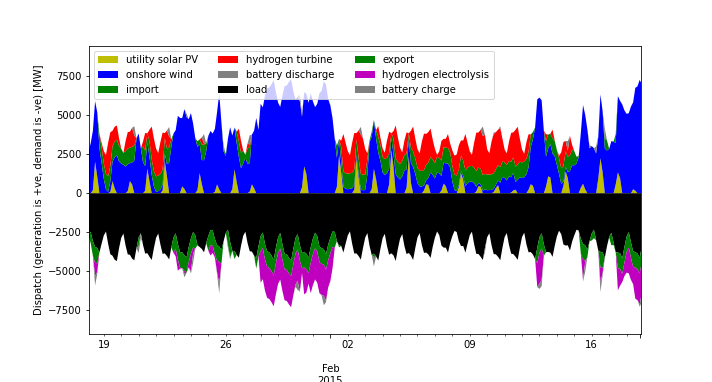

False
[4375.855833333333, -7886.82688, 7886.8269]


/home/mcmullib/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1282: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


In [111]:
%matplotlib notebook

fig, ax = plt.subplots()
#fig.set_size_inches((10,8))

rename = {"ic-import" : "import",
          "ic-export" : "export",
          "wind" : "onshore wind",
          "solar" : "utility solar PV",
          "battery discharge" : "battery discharge",
          "battery charge" : "battery charge",
          "H2 electrolysis" : "hydrogen electrolysis",
          "H2 to power" : "hydrogen turbine"}

rename = {ct + " "+k : v for k,v in rename.items()}

rename[ct] = "load"

colors = {"import" : "g",
           "export" : "g",
           "onshore wind" : "b",
           "utility solar PV" : "y",
           "battery discharge" : "gray",
           "battery charge" : "gray",
           "load" : "k",
           "hydrogen electrolysis" : "m",
           "hydrogen turbine" : "r"
          }

# KLUDGE: for some reason (solver tolerance?) some solution values that should be strictly 
# positive or negative may be infinitesimally (< 10e-10) of the other sign. This will cause 
# df.plot(stacked=True) to throw an error (requires all values to have same sign, positive or 
# negative). So we do a somewhat ugly ".round(10)" kludge to fix it...

positive = pd.concat((network.generators_t.p,
                      -network.links_t.p1[[ct+" ic-import",ct+" H2 to power",ct+" battery discharge"]]),
                     axis=1).rename(columns=rename).round(10)
negative = pd.concat((-network.loads_t.p,
                      -network.links_t.p0[[ct+" ic-export",ct+" H2 electrolysis",ct+" battery charge"]]),
                     axis=1).rename(columns=rename).round(10)

print((abs(positive.sum(axis=1) + negative.sum(axis=1)) > 0.1).any())

load_max=network.loads_t.p.sum(axis=1).max()
gen_max=positive.sum(axis=1).max()
demand_max=negative.sum(axis=1).min()

print([load_max,demand_max,gen_max])

positive.loc[plt_start:plt_stop].plot(kind="area",stacked=True,ax=ax,linewidth=0,
                              color=[colors[i] for i in positive.columns])

negative.loc[plt_start:plt_stop].plot(kind="area",stacked=True,ax=ax,linewidth=0,
                              color=[colors[i] for i in negative.columns])

ax.set_ylim([1.2*demand_max, 1.2*gen_max])
ax.set_xlim([plt_start,plt_stop])
ax.set_ylabel("Dispatch (generation is +ve, demand is -ve) [MW]")
ax.legend(ncol=3,loc="upper left")

#fig.tight_layout()
#fig.savefig("img/{}-{}-{}-{}.png".format(ct,scenario,start,stop),dpi=100)

<IPython.core.display.Javascript object>


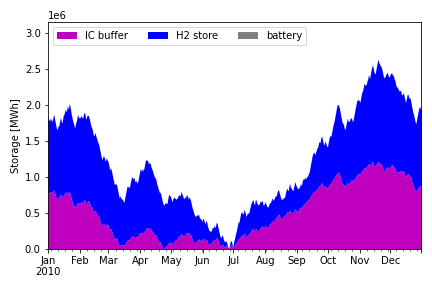

,IC buffer,H2 store,battery
2010-01-01 00:00:00,802173.46,1041995.80,-0.00
2010-01-01 03:00:00,801651.04,1039193.90,-0.00
2010-01-01 06:00:00,799783.58,1036391.90,-0.00
2010-01-01 09:00:00,795105.90,1033589.90,-0.00
2010-01-01 12:00:00,789738.45,1030788.00,-0.00
...,...,...,...
2010-12-31 09:00:00,835408.72,1056005.70,-0.00
2010-12-31 12:00:00,827200.73,1053203.70,-0.00
2010-12-31 15:00:00,817945.30,1050401.70,-0.00
2010-12-31 18:00:00,809053.57,1047599.80,-0.00


[-8216.9134, 8216.9134]


In [96]:
%matplotlib notebook

fig, ax = plt.subplots()
#fig.set_size_inches((10,8))

"H2 store underground"
"H2 store tank"
"battery storage"

rename = {"ext-grid-buffer" : "IC buffer", "H2 store" : "H2 store",
    "battery storage" : "battery"}

rename = {ct + " "+k : v for k,v in rename.items()}

colors = {"IC buffer" : "m",
        "H2 store" : "b",
        "battery" : "gray"}

storage = network.stores_t.e[[ct+" ext-grid-buffer",ct+" H2 store",
                              ct+" battery storage"]].rename(columns=rename).round(10)
display(storage)

storage.loc[plt_start:plt_stop].plot(kind="area",stacked=True,ax=ax,linewidth=0,
                              color=[colors[i] for i in storage.columns])

e_max = storage.sum(axis=1).max()
e_min = storage.sum(axis=1).min()

#ax.set_ylim([demand_max,gen_max])
print([demand_max,gen_max])
ax.set_ylim([0.0, 1.2*e_max])
ax.set_xlim([plt_start,plt_stop])
ax.set_ylabel("Storage [MWh]")
ax.legend(ncol=3,loc="upper left")

fig.tight_layout()

#fig.savefig("img/{}-{}-{}-{}.png".format(ct,scenario,start,stop),dpi=100)

## Solve a single year for various time resolutions (`snapshot_interval`)

In [ ]:
run_configs = pd.DataFrame()
r_id_stem = 'SI-'

for snapshot_interval in [1, 3, 6, 12, 24] :
    r_id = r_id_stem+str(snapshot_interval)+"H"
    run_configs.at['snapshot_interval', r_id] = snapshot_interval # hours
    # Available year(s) for weather data: solar 1985-2015 inclusive, wind 1980-2016
    run_configs.at['weather_year_start', r_id] = 2015 
    run_configs.at['weather_year_end', r_id] = 2015
    run_configs.at['load_year_start', r_id] = 2015
    run_configs.at['load_year_end', r_id] = 2015
    run_configs.at['assumptions_year', r_id] = 2030 # Used to select projected nominal cost 
    run_configs.at['usd_to_eur', r_id] = 0.90 
    run_configs.at['h_store_underground_max_e (TWh)', r_id] = +np.inf
    run_configs.at['h_store_tank_max_e (TWh)', r_id] = +np.inf 

display(run_configs)

In [ ]:
run_stats = pd.DataFrame()
for r_id in run_configs.columns :
    print(r_id)
    network = solve_network(r_id)
    gather_run_stats(r_id,network)

In [ ]:
display(run_stats)

## Solve the system for a batch of discrete years

In [ ]:
run_configs = pd.DataFrame()
r_id_stem = 'WY-'

for weather_year_start in range(2007, 2015, 1) :
    r_id = r_id_stem+str(weather_year_start)
    run_configs.at['snapshot_interval', r_id] = 12 # hours
    # Available year(s) for weather data: solar 1985-2015 inclusive, wind 1980-2016
    run_configs.at['weather_year_start', r_id] = weather_year_start 
    run_configs.at['weather_year_end', r_id] = weather_year_start
    run_configs.at['load_year_start', r_id] = 2015
    run_configs.at['load_year_end', r_id] = 2015
    run_configs.at['assumptions_year', r_id] = 2030 # Used to select projected nominal cost 
    run_configs.at['usd_to_eur', r_id] = 0.90 
    run_configs.at['h_store_underground_max_e (TWh)', r_id] = +np.inf
    run_configs.at['h_store_tank_max_e (TWh)', r_id] = 1.0 

display(run_configs)

In [ ]:
run_stats = pd.DataFrame()
for r_id in run_configs.columns :
    print(r_id)
    network = solve_network(r_id)
    gather_run_stats(r_id,network)

In [ ]:
display(run_stats)

## Extra outputs (WHOBS legacy)

**FIXME:** Need to review which - if any - of these are still relevant, and indeed, *correctly implemented*, in WHOBS-IE-100...

In [ ]:
#relative market value
(network.generators_t.p.multiply(network.buses_t.marginal_price[ct],axis=0).sum()/
     network.generators_t.p.sum())/network.buses_t.marginal_price[ct].mean()

In [ ]:
#relative market value
(network.links_t.p0.multiply(network.buses_t.marginal_price[ct],axis=0).sum()/
     network.links_t.p0.sum())/network.buses_t.marginal_price[ct].mean()

In [ ]:
network.buses_t.marginal_price.plot()

In [ ]:
network.buses_t.marginal_price.mean()

In [ ]:
network.links_t.p0.mean()/network.links.p_nom_opt

In [ ]:
%matplotlib notebook

opt_costs = pd.Series()


opt_costs = pd.concat((opt_costs,network.generators.capital_cost*network.generators.p_nom_opt))

opt_costs = pd.concat((opt_costs,network.links.capital_cost*network.links.p_nom_opt))

opt_costs = pd.concat((opt_costs,network.stores.capital_cost*network.stores.e_nom_opt))


(opt_costs/opt_costs.sum()).plot(kind="bar",grid=True)


In [ ]:
display(opt_costs/1e9) # €B

## Reflections (random, possibly defunct!)

+ I don't really have a good intuition for why battery storage is being used at the level it is. Presumably if we go to more coarse-grained temporal resolution it stops being used altogether?
+ Battery and DSM (including heating and vehicle charging flexibilities) presumablly all fall into the same ~24 hour flexibility regime.
+ Flow batteries would, presumably, have a quite different profile: maybe conceivably competitive with ammonia? Could we add a model of that?